## RAG with Langgraph Agent

In [10]:
# use the langchain pre-release for latest features
# pip install --pre -U langchain langchain-ollama, langchain-chroma, langchain-core langchain-community

# for stable version once v1 is released
# pip install langchain langchain-ollama, langchain-chroma, langchain-core langchain-community

In [11]:
from typing import Literal
from pydantic import BaseModel, Field

# Core imports
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

from dotenv import load_dotenv
load_dotenv('./../.env')

False

In [12]:
# ============================================================================
# STEP 1: CONNECT TO EXISTING VECTOR STORE
# ============================================================================
print("Connecting to existing Chroma vector store...")

# Use the same embeddings as your ingestion code
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    base_url="http://localhost:11434"
)

# Chroma Vector Store (assumes data already exists from previous code)
vector_store = Chroma(
    collection_name="pdf_collection",
    embedding_function=embeddings,
    persist_directory="../01-semantic-search/chroma_db"
)

print("✓ Connected to existing vector store")


Connecting to existing Chroma vector store...
✓ Connected to existing vector store


In [13]:
print("\n🔍 Testing Vector Store Connection...")

# Test 1: Check collection info
collection = vector_store._collection
doc_count = collection.count()
print(f"✓ Collection '{collection.name}' found with {doc_count} documents")



🔍 Testing Vector Store Connection...
✓ Collection 'pdf_collection' found with 270 documents


In [14]:
# ============================================================================
# STEP 2: CREATE RETRIEVER TOOL
# ============================================================================
@tool
def retrieve_documents(query: str):
    """Search and return information from the PDF documents in the database."""
    print(f"🔍 Searching: '{query}'")
    
    # Perform similarity search using the retriever
    docs = vector_store.similarity_search(query,k=4)
    
    # Format results for the LLM
    if docs:
        content = "\n\n".join(
            f"Page {doc.metadata.get('page', '?')}: {doc.page_content}" 
            for doc in docs
        )
        print(f"✓ Found {len(docs)} relevant chunks")
        return content
    else:
        print("✗ No relevant documents found")
        return "No relevant information found."

retriever_tool = retrieve_documents

print("✓ Created retriever tool")

✓ Created retriever tool


In [15]:
# ============================================================================
# STEP 3: INITIALIZE MODELS
# ============================================================================
# Using ChatOllama instead of OpenAI
response_model = ChatOllama(
    model="llama3.2:3b", 
    base_url="http://localhost:11434",
    temperature=0
)
grader_model = ChatOllama(
    model="llama3.2:3b", 
    base_url="http://localhost:11434",
    temperature=0
)

print("✓ Initialized chat models")


✓ Initialized chat models


In [16]:
# ============================================================================
# STEP 4: NODE FUNCTIONS
# ============================================================================

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [17]:
# Document grading
GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.\n"
    "Only respond with 'yes' or 'no'."
)

def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = grader_model.invoke([{"role": "user", "content": prompt}])
    
    # Extract the score from the response content
    # Handle both string and list content types
    content = response.content
    if isinstance(content, list):
        # If content is a list, join it or take the first element
        score = " ".join(str(item) for item in content).strip().lower()
    else:
        score = str(content).strip().lower()
    
    # Ensure we only get 'yes' or 'no'
    if "yes" in score:
        return "generate_answer"
    else:
        return "rewrite_question"

In [18]:
# Question rewriting
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}


In [19]:
# Answer generation
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)

def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}





In [20]:
# ============================================================================
# STEP 5: ASSEMBLE THE GRAPH
# ============================================================================
workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

print("✓ Assembled and compiled the graph")


✓ Assembled and compiled the graph


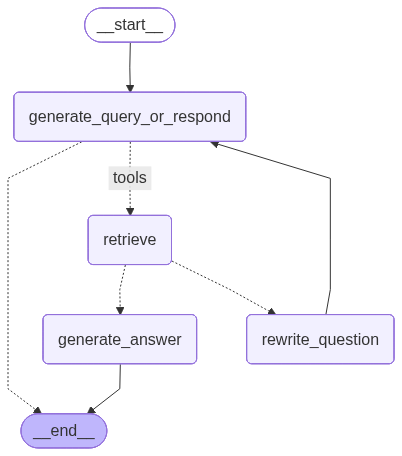

In [21]:
graph

In [22]:
# ============================================================================
# STEP 6: TEST THE AGENTIC RAG
# ============================================================================
def run_agentic_rag(question: str):
    """Run the agentic RAG system with a question"""
    print(f"\n{'='*60}")
    print(f"QUESTION: {question}")
    print(f"{'='*60}")
    
    # MessagesState accepts shorthand message format via add_messages reducer
    for chunk in graph.stream({"messages": [{"role": "user", "content": question}]}):  # type: ignore
        for node, update in chunk.items():
            print(f"\nUpdate from node: {node}")
            print("-" * 40)
            print(update["messages"][-1])
            print()

In [23]:
question = "What are the main methods mentioned in this paper?"
run_agentic_rag(question)



QUESTION: What are the main methods mentioned in this paper?

Update from node: generate_query_or_respond
----------------------------------------
content='' additional_kwargs={} response_metadata={'model': 'llama3.2:3b', 'created_at': '2025-11-24T20:18:21.173892Z', 'done': True, 'done_reason': 'stop', 'total_duration': 15807218955, 'load_duration': 7338167498, 'prompt_eval_count': 164, 'prompt_eval_duration': 7124845757, 'eval_count': 20, 'eval_duration': 1166666155, 'logprobs': None, 'model_name': 'llama3.2:3b', 'model_provider': 'ollama'} id='lc_run--9d327291-653b-4f7e-8734-fcbbc3168259-0' tool_calls=[{'name': 'retrieve_documents', 'args': {'query': 'main methods in paper'}, 'id': '516cd0d4-18b3-4457-88bd-af8bd60c2805', 'type': 'tool_call'}] usage_metadata={'input_tokens': 164, 'output_tokens': 20, 'total_tokens': 184}

🔍 Searching: 'main methods in paper'
✓ Found 4 relevant chunks

Update from node: retrieve
----------------------------------------
content='Page 0: Chapter 4. Work

KeyboardInterrupt: 

In [ ]:
question = "Tell me about earth"
run_agentic_rag(question)


QUESTION: Tell me about earth

Update from node: generate_query_or_respond
----------------------------------------
content='<think>\nOkay, the user asked "Tell me about earth." I need to figure out how to respond. Let me check the tools available. There\'s a function called retrieve_documents that searches PDF documents in the database. The function requires a query parameter. Since the user is asking about Earth, I should use this function to get information from the documents. The query parameter should be "Earth" or "about Earth." Let me call the function with "Earth" as the query. That should retrieve the relevant information from the PDFs. I\'ll structure the tool call accordingly.\n</think>\n\n' additional_kwargs={} response_metadata={'model': 'qwen3', 'created_at': '2025-09-21T17:04:20.7535156Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1001018200, 'load_duration': 48519900, 'prompt_eval_count': 146, 'prompt_eval_duration': 53650200, 'eval_count': 138, 'eval_dura